## Анализ необходимого количества наблюдений, размера эффекта и мощности критериев с помощью *statsmodels.stats.power* (согласно подходу Fixed Horizon)

In [4]:
import math
import numpy as np
import statsmodels.stats.power as smp
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Критерий пропорций (нужен для кликов, конверсий). Ниже посчитаем прогноз, в котором мы хотели бы увидеть разницу p_x и p_y.
# Когда подойдет время сравнения экспериментального эффекта с прогнозом, нам таким же образом нужно взять все экспериментальные
# параметры и сравнить их. Например, прогнозный h с фактическим (экспериментальным) h
alpha = 0.05
power = 0.5
n = 450
p_x = 0.25
p_y = 0.2875

h = 2*math.asin(np.sqrt(p_x)) - 2*math.asin(np.sqrt(p_y))

In [84]:
h

-0.08463688998853836

In [85]:
# Сколько наблюдений необходимо для заданного эффекта, чтобы
# результаты двухвыборочного теста пропорций были с заданным уровнем значимости 
# и заданной мощностью критерий (1 - вероятность ошибки II-го рода)

smp.zt_ind_solve_power(effect_size = h, alpha = alpha, power = power, alternative='two-sided')

1072.4018713796613

In [86]:
# Какая мощность критерия будет в выборке из n наблюдений, 
# при условии, что величина эффекта = h c уровнем значимости alpha

power = smp.zt_ind_solve_power(effect_size=h, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.2455879922354528

In [87]:
# Какова величина эффекта будет при рассчете теста, при заранее заданных
# величинах альфа и величины мощности 
smp.zt_ind_solve_power(nobs1 = n, alpha = alpha, power = power)

0.0846366124937545

## t-Критерий Стьюдента (принцип такой же, какой и сверху)

In [17]:
effects = []
sample_sizes = []

for i in tqdm(range(50,2000)):
    effects.append(smp.tt_ind_solve_power(nobs1 = i, alpha = alpha, power = power))
    sample_sizes.append(i)

In [18]:
effects[:10]

[0.6100781117119797,
 0.6039473708160531,
 0.5979987726385927,
 0.592217508992714,
 0.5866052697062207,
 0.5811494490351803,
 0.5758429413270946,
 0.5706790950542528,
 0.5656516708182788,
 0.5607548033983814]

Text(0, 0.5, 'Effect Amount')

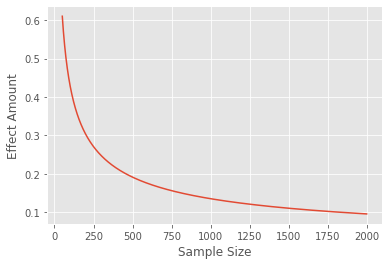

In [19]:
viz = sns.lineplot(x=sample_sizes, y=effects)
viz.set_xlabel("Sample Size")
viz.set_ylabel("Effect Amount")

# Сколько времени ждать для достижения % изменения метрики?

### Выберите метрику и посчитайте mean , std

Посчитайте для этого показателя величину среднее и стандартное отклонение по выборке за достаточно длительный период ( 2-5 недель). Это будет константами, которые будут использоваться далее в расчетах необходимой выборки на эксперимент

### Выберите lift от 0.01 до 1.00 (где 1.00 – 100% прироста у метрики). 

Стоит учитывать, что в зависимости от метрики у нас есть ограничения в наблюдениях и претендовать на маленькие эффекты не получится. Чтобы получить меньший эффект на тех же наблюдениях, необходимо повышать чувствительность метрики:

### Рассчитайте Effect Size 

Дальше мы будем использовать `tt_solve_power` из модуля `scipy.stats`. На вход будем подавать `ES` по следующей формуле: `effect_size = mean / sd * lift`. Это приближение работает так же как формула из лекции

### Выберите стат. параметры уровня значимости $\alpha$ и уровня мощности $1-\beta$

**Рекомендации**
- Уровень мощности не менее 80%
- Уровень значимости не менее 95% (чем больше – тем лучше). Стоит учесть множественный поправки и  FWER (family wise error rate). Используйте поправку Бонферонни: $\alpha\over{m}$, где $m$ количество рассматриваемых гипотез (парных сравнений). При таком отношении фиксируется изначальный уровень $\alpha$

### Считаем кол-во наблюдений

In [12]:
from statsmodels.stats.power import tt_ind_solve_power 
mean = 2021.989 # рассчитанное среднее за 2-5 недель
se = 2425.011 # рассчитанное стандартное отклонение за тот же период
power = 0.9
alpha = 0.005
lift = 0.1 # хотим увидеть 10% изменение в метрику
effect_size = mean / se * lift 
print(effect_size)

0.08338061146939128


In [6]:
# Результат – наблюдения на одну выборку (соотвественно, умножаем на 2)
print(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1))

4810.872941082196


Результатом будет необходимое количество наблюдений на одну выборку. Т.к. расчеты предполагают соотношение 50%/50% в группах А и Б, то полученное число нужно умножить на 2. 

# На какой эффект я могу рассчитывать, если у меня ограниченное количество наблюдений?

### Посчитайте количество доступных наблюдений

Допустим, вы обладаете ограниченной базой пользователей на которые будет запускаться эксперимент. Это число и будет значением аргумента `nobs`

In [6]:
from statsmodels.stats.power import tt_ind_solve_power 
nobs = 4810.872941082196 # возьмем то же самое число, что в прошлом примере
power = 0.9
alpha = 0.005

# Результат – допустимый минимальный effect_size 
print(tt_ind_solve_power(alpha=alpha, power=power, nobs1=nobs, ratio=1))

0.08338074468542343


Функция `tt_ind_solve_power` возвращает значение для одного из 4 аргументов, который пропущен (None). 

Поэтому, при известном размере выборки, уровне значимости и мощности, мы получаем в результате `effect_size`

In [144]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns


N = 2000
n = int(N/2)
mu = 10 
sigma = 2
lift = 1.1
pwr = 0.8 
alpha = 0.05

res = pd.DataFrame()

# Объявим тестовые данные
np.random.seed(1)
pd_df = pd.DataFrame({
    "val": np.concatenate([np.random.normal(mu, sigma, n), np.random.normal(mu*lift, sigma, n)]),
    "grp": np.concatenate([np.repeat("c",n),np.repeat("t",n)])
})
pd_df = pd_df.sample(frac=1)

# Кумулятивно считаем MDE в ходе эксперимента
for i in range(10,len(pd_df)):
    t = pd_df.iloc[:i, :]
    df = len(t) - 2 # степени свободы
    sd_t = np.std(t['val'][t['grp'] == 't'])
    sd_c = np.std(t['val'][t['grp'] == 'c'])
    n_t = len(t[t['grp'] == 't'])
    n_c = len(t[t['grp'] == 'c'])
    
    y_c = np.mean(t['val'][t['grp'] == 'c'])
    S = np.sqrt((sd_t**2 / n_t) + (sd_c**2 / n_c))
    M = scipy.stats.t.ppf(pwr, df) - scipy.stats.t.ppf(alpha / 2, df)  # расчет квантилей t-распределения
    
    to_insert = {
        "n": len(t.index),
        "mde": M * S,
        "mde_perc": M * S / y_c
    }
    
    res = res.append(to_insert, ignore_index=True)

In [145]:
res

,mde,mde_perc,n
0,3.238307,0.382492,10.0
1,2.791325,0.329697,11.0
2,2.451161,0.289518,12.0
3,2.187860,0.258419,13.0
4,2.013473,0.237821,14.0
...,...,...,...
1985,0.252384,0.025050,1995.0
1986,0.252332,0.025045,1996.0
1987,0.252315,0.025043,1997.0
1988,0.252300,0.025042,1998.0


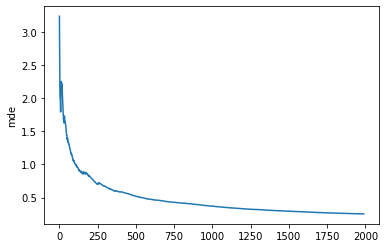

In [148]:
plt.plot(res['mde'])
plt.ylabel('mde')
plt.show()

In [150]:
mean = 2021.989 # рассчитанное среднее 5 недель
se = 2425.011 # рассчитанное стандартное отклонение за тот же период
power = 0.9
alpha = 0.005
es = []
n = []

lift_list = np.arange(0.01,0.11,0.01)
for lift in lift_list:
    effect_size = mean / se * lift
    res = tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1)
    n.append(res)
    es.append(effect_size)
    
pd_res = pd.DataFrame({"n": np.round(n), "lift": lift_list, "es": es})    
pd_res

,n,lift,es
0,480892.0,0.01,0.008338
1,120225.0,0.02,0.016676
2,53434.0,0.03,0.025014
3,30058.0,0.04,0.033352
4,19238.0,0.05,0.041690
5,13360.0,0.06,0.050028
6,9816.0,0.07,0.058366
7,7516.0,0.08,0.066704
8,5939.0,0.09,0.075043
9,4811.0,0.10,0.083381


# Проверим на живых данных

In [111]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind_from_stats
from statsmodels.stats.power import tt_ind_solve_power

df = pd.read_csv("/Users/iskander/Documents/RProjects/dm_jira_shiny/df.csv",sep=";")
del df['Unnamed: 0']
display(df)

,date,driver_id,orders_count,driver_bill,fee,split
0,2019-05-05,20143475,25,3545,1055,2
1,2019-05-05,31756631,40,6096,1404,1
2,2019-05-05,23579087,25,4179,421,2
3,2019-05-05,29829135,40,6293,1207,1
4,2019-05-05,31118111,23,4307,0,1
...,...,...,...,...,...,...
4962,2019-06-26,28387903,5,1088,0,2
4963,2019-06-26,14267206,7,1482,0,1
4964,2019-06-26,32298863,1,258,0,1
4965,2019-06-26,28113731,1,145,35,1


### Считаем тоталы по метриками и стандартное отклонение

In [112]:
def agg_totals(df):    
    """Ф-ция расчета агрегат"""
    
    names = {
        "gmv": df['driver_bill'].sum(),
        "cost": df['fee'].sum(),
        "orders_count": df['orders_count'].sum(),
        'n': df['driver_id'].nunique(),
        "orders_per_driver": df['orders_count'].sum() / df['driver_id'].nunique(),
        "gmv_per_driver": df['driver_bill'].sum() / df['driver_id'].nunique()
    }
    return pd.Series(names)

def pivot_df(df, col_names=['metric_name', 'value_1', 'value_2']):
    """Пивот таблицы для удобной работы c расчетом fixed horizon"""
    
    df = pd.melt(df, id_vars=['split']) \
        .pivot_table(index=['variable'], columns=['split'], values='value') \
        .reset_index()
    df.columns = col_names
    return df


# Препроцесс
split_level_agg = pivot_df(
    df.groupby('split').apply(agg_totals).reset_index()
)

# отдельно считаем группировку по пользователям, чтобы независимо посчитать дисперсию (т.к. в оригинале дубли)
driver_level_agg = pivot_df(
    df.groupby(['split','driver_id']).apply(agg_totals).reset_index(), ['metric_name', 'std_1', 'std_2']
)

exp_res = split_level_agg.merge(driver_level_agg)
exp_res['n_1'] = int(split_level_agg['value_1'][split_level_agg.metric_name == 'n'])
exp_res['n_2'] = int(split_level_agg['value_2'][split_level_agg.metric_name == 'n'])

### Смотрим что получилось

In [113]:
exp_res

,metric_name,value_1,value_2,std_1,std_2,n_1,n_2
0,cost,5.947010e+05,4.379190e+05,3716.88125,2900.125828,160,151
1,gmv,6.456254e+06,6.337583e+06,40351.58750,41970.748344,160,151
2,gmv_per_driver,4.035159e+04,4.197075e+04,40351.58750,41970.748344,160,151
3,n,1.600000e+02,1.510000e+02,1.00000,1.000000,160,151
4,orders_count,3.566900e+04,3.447000e+04,222.93125,228.278146,160,151
5,orders_per_driver,2.229313e+02,2.282781e+02,222.93125,228.278146,160,151


### Считаем pvalue, lift, mde, необходимый объем выборки

In [119]:
alpha = 0.05
power = 0.8

# расчет t-критерия из готовых статистик
_, exp_res['pvalue'] = ttest_ind_from_stats(
    mean1 = exp_res['value_1'], 
    std1 = exp_res['std_1'], 
    nobs1 = exp_res['n_1'], 
    mean2 = exp_res['value_2'], 
    std2 = exp_res['std_2'], 
    nobs2 = exp_res['n_2'], 
    equal_var = False)

# считаем стандартизированный эффект сайз с которым потом будем сравнивать mde
exp_res['lift'] = (exp_res['value_2'] - exp_res['value_1']) / exp_res['value_1']
exp_res['effect_size'] = abs(exp_res['value_1'] / exp_res['std_1'] * exp_res['lift'])

# Считаем мде и необходимое количество наблюдений. 
exp_res['mde'] = [tt_ind_solve_power(nobs1=row[0], alpha=alpha, power=power) for row in zip(exp_res['n_1'])]
exp_res['n_need'] = [tt_ind_solve_power(row[0], alpha=alpha, power=power) for row in zip(exp_res['effect_size'])]

# Увидим ошибки, но не обращаем внимания на них. В первом случае нереально большой эффект, а во втором дисперсия равная единице
# также не обращаем внимание на метрики n, orders_count, gmv
exp_res = exp_res[~exp_res.metric_name.isin(['n','orders_count','gmv'])]
display(exp_res)

/Users/iskander/Documents/PyProjects/mv_variance/lib/python3.8/site-packages/statsmodels/stats/power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)
/Users/iskander/Documents/PyProjects/mv_variance/lib/python3.8/site-packages/statsmodels/stats/power.py:415: ConvergenceWarning: 
Failed to converge on a solution.

  warnings.warn(convergence_doc, ConvergenceWarning)


,metric_name,value_1,value_2,std_1,std_2,n_1,n_2,pvalue,lift,effect_size,mde,n_need
0,cost,594701.00000,437919.000000,3716.88125,2900.125828,160,151,0.000000,-0.263632,42.181062,0.314176,[10.0]
2,gmv_per_driver,40351.58750,41970.748344,40351.58750,41970.748344,160,151,0.729243,0.040126,0.040126,0.314176,9750.36
5,orders_per_driver,222.93125,228.278146,222.93125,228.278146,160,151,0.834738,0.023985,0.023985,0.314176,27289.2
